# **Modèles pour classification textuelles**

Une fois les données nettoyées dans le notebook `1. Preprocessing` précédent, nous allons maintenant utiliser plusieurs modèles pour tenter de modéliser

# 1. Avant propos et méthodologie

## 1.1 Premiers éléments

Nous allons faire de la classification textuelle avec _overlapping_ de labels.
Les labels sont équilibrés, à priori pas besoin d'utiliser les méthodes spécifiques au _imbalanced dataset_

## 1.2 Modèles utilisés

Les modèles utilisés, classés par "ordre de complexité" sont les suivants :
- Bag of Words
- TF-IDF
- Embedding statique _a la_ word2vec
- Combinaison des deux méthodes pour faire du doc/sent2vec où les pondérations par mot sont données par le TF-IDF
- Embedding "dynamique" en ayant recours à un transformers, ici BERT

# 2. Packages usuels et importation

In [1]:
# Pour faciliter la mise à jour des fonctions écrites dans func_custom sans avoir à redémarrer le kernel
%load_ext autoreload
%autoreload 2

In [10]:
# Packages classiques
import pandas as pd

# Custom package
import func_custom as fc

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [11]:
df_train = pd.read_csv("data/data_clean.csv",
                       sep = ";")

In [29]:
df_train["label_1"] = df_train["label"].apply(lambda x : "1" in x)
df_train["label_8"] = df_train["label"].apply(lambda x : "8" in x)

In [73]:
# Transformer en une liste
documents = df_train["message_clean"].tolist()
labels = df_train["label_1"].tolist()

# 3. TF_IDF

In [ ]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
X = vectorizer.fit_transform(documents)

In [47]:
# Step 3: Train a classifier
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Step 4: Evaluate your model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [48]:
print(report)

              precision    recall  f1-score   support

       False       0.95      0.40      0.56        98
        True       0.65      0.98      0.78       112

    accuracy                           0.71       210
   macro avg       0.80      0.69      0.67       210
weighted avg       0.79      0.71      0.68       210



# 4. XGBoost

In [51]:
import xgboost as xgb
from sklearn.linear_model import Lasso

In [68]:
# Step 3: Train a classifier
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3)
classifier = MultinomialNB()
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

# Step 4: Evaluate your model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [69]:
print(report)

              precision    recall  f1-score   support

       False       0.77      0.73      0.75        98
        True       0.78      0.81      0.79       112

    accuracy                           0.78       210
   macro avg       0.78      0.77      0.77       210
weighted avg       0.78      0.78      0.78       210



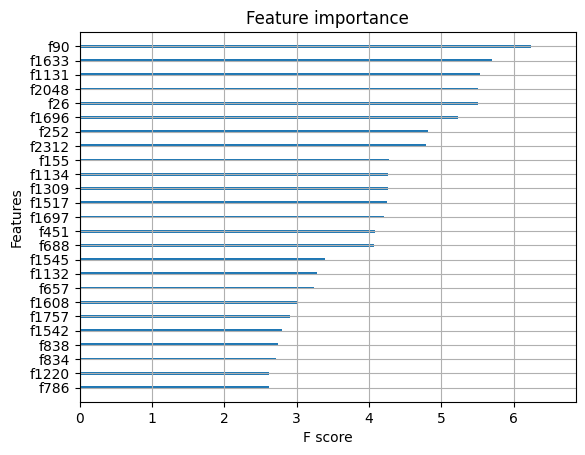

In [70]:
_ = xgb.plot_importance(classifier, 
                        importance_type = "gain",
                        max_num_features = 25,
                        show_values = False)

# 4. Word2vec

In [74]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

word2vec_model = Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

def get_document_vector(doc, model):
    valid_words = [word for word in doc if word in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

In [75]:
df_train

,label,message,message_clean,label_1,label_8
0,8,"Madame,Monsieur, je me permet de vous envoyer ...",madam monsieur permet envoi courriel car vien ...,False,True
1,8,je désire connaitre quel est le montant de mo...,désir connaitr quel mont impot revenu concern...,False,True
2,8,"Bonjour, Je fais suite du dernier message envo...",bonjour fais suit derni messag envoyé concern...,False,True
3,8,"Bonjour, Je me permets de vous contacter afin ...",bonjour permet contact afin obten répons déc...,False,True
4,8,"Madame, Monsieur, Après avoir déclaré nos r...",madam monsieur aprè avoir déclaré revenus m...,False,True
...,...,...,...,...,...
695,8,"Bonjour, Depuis que j'ai déclaré mon PACS av...",bonjour depuis déclaré pac mr retrait baisse...,False,True
696,8,"Bonjour, Je voudrais opter pour le taux de pre...",bonjour voudr opter taux prélèv individualis...,False,True
697,1,Bonjour Madame Monsieur Je signale un changeme...,bonjour madam monsieur signal chang situat fam...,True,False
698,8,"Bonjour, Je dois déclarer un changement de si...",bonjour dois déclar chang situat famill pac c...,False,True


In [76]:
df_train['doc_vector'] = df_train['message_clean'].apply(lambda x: get_document_vector(x, word2vec_model))

# Prepare feature and target variables
X = np.vstack(df_train['doc_vector'].values)
y = df_train['label_1']

In [79]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5


c:\Users\TitouanBlaize\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TitouanBlaize\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TitouanBlaize\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
X.shape

(700, 100)

In [80]:
print(report)

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        70
        True       0.50      1.00      0.67        70

    accuracy                           0.50       140
   macro avg       0.25      0.50      0.33       140
weighted avg       0.25      0.50      0.33       140

